In [1]:
import tensorflow as tf
import numpy as np
import collections
from keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import unicodedata
import string
import re

def read_data(fname):
    with open("/kaggle/input/tieu-su-elon-musk-1/Tieu_su_Elon_Musk.txt", "r", encoding="utf-8") as f:
        text = f.read()
        cleaned_text = clean_text(text).split()
        return cleaned_text


def build_dataset(words):
    count = collections.Counter(words).most_common()
    word2id = {}
    for word, freq in count:
        word2id[word] = len(word2id)
        id2word = dict(zip(word2id.values(), word2id.keys()))
    return word2id, id2word

def clean_text(text):
    # 1. Chuyển về chữ thường
    text = text.lower()

    # 2. Chuẩn hóa unicode (tránh lỗi dấu tiếng Việt)
    text = unicodedata.normalize("NFC", text)

    # 3. Loại bỏ dấu câu (chấm, phẩy, ngoặc...)
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 4. Loại bỏ khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()

    return text

data = read_data('/kaggle/input/tieu-su-elon-musk-1/Tieu_su_Elon_Musk.txt')
print("Tổng số từ: ", len(data))
print("In ra 10 từ đầu tiên: \n", data[:10])

w2i, i2w = build_dataset(data)
vocab_size = len(w2i)
timestep = 3
print("Kích thước túi từ vựng: ", vocab_size)

X, Y = [], []
for i in range(timestep, len(data)):
    X.append([w2i[data[k]] for k in range(i-timestep, i)])
    Y.append(w2i[data[i]])

encoded_data = [w2i[x] for x in data]
X = encoded_data[:-1]  # Cắt đúng timestep cuối
Y = encoded_data[timestep:]

# Tạo dataset từ chuỗi thời gian
train_data = tf.keras.preprocessing.timeseries_dataset_from_array(
    X, Y, sequence_length=timestep, sampling_rate=1
)

for batch in train_data.take(1):  # Lấy 1 batch đầu tiên để xem
    X_batch, Y_batch = batch
    print("X batch:", X_batch.numpy()[:10, :])  # Chuyển Tensor thành NumPy để dễ đọc
    print("Y batch:", Y_batch.numpy()[:10])

for X_batch, Y_batch in train_data.take(1):  # Lấy 1 batch đầu tiên
    print("Số mẫu trong batch:", X_batch.shape[0])  # Số hàng trong X_batch


Tổng số từ:  7969
In ra 10 từ đầu tiên: 
 ['elon', 'reeve', 'musk', 'sinh', '28', 'tháng', '6', 'năm', '1971', 'là']
Kích thước túi từ vựng:  1426
X batch: [[ 21 850   2]
 [850   2 123]
 [  2 123 623]
 [123 623  14]
 [623  14 146]
 [ 14 146   0]
 [146   0 624]
 [  0 624   7]
 [624   7   4]
 [  7   4 209]]
Y batch: [123 623  14 146   0 624   7   4 209  23]
Số mẫu trong batch: 128


In [4]:
# Xây mô hình
model = tf.keras.Sequential()
model.add(Input(shape=(timestep, 1))),
model.add(LSTM(512, return_sequences=True,))
model.add(LSTM(512, return_sequences=False))
model.add(Dense(vocab_size))
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor="loss",  # Theo dõi loss trên tập validation (đúng)
    mode="min", 
    patience=30,          
    restore_best_weights=True,  
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="loss",  # Theo dõi loss trên tập validation (đúng)
    factor=0.5,           
    patience=10,           
    min_lr=1e-6,          
    verbose=1             
)

# Chạy training với tập validation
history = model.fit(
    train_data,
    epochs=500, 
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 512)              │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1426)                │         731,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,883,410 (14.81 MB)

 Trainable params: 3,883,410 (14.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0165 - loss: 6.8798 - learning_rate: 0.0010
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0250 - loss: 6.3917 - learning_rate: 0.0010
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0321 - loss: 6.3056 - learning_rate: 0.0010
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0338 - loss: 6.0975 - learning_rate: 0.0010
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0319 - loss: 5.9315 - learning_rate: 0.0010
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0379 - loss: 6.0008 - learning_rate: 0.0010
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0332 - loss: 6.0863 - learning_rate: 0.0010
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0358 - loss: 6.0000 - learning_rate: 0.0010
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0379 - loss: 5.8948 - learning_rate: 0.0010
Epoch 10/500
63/6

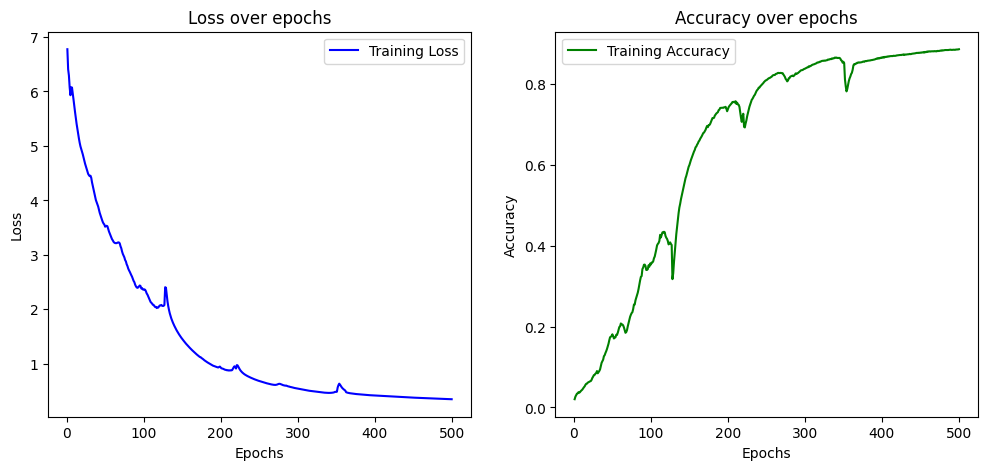

In [5]:
import matplotlib.pyplot as plt
from tensorflow import keras
history = model.history 
# Vẽ loss và accuracy
def plot_history(history):
    # Lấy dữ liệu loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Có thể không có val_loss
    acc = history.history.get('accuracy', None)  # Có thể không có accuracy
    val_acc = history.history.get('val_accuracy', None)  # Có thể không có val_accuracy
    epochs = range(1, len(loss) + 1)

    # Vẽ Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)  # Chia thành 2 đồ thị, đây là đồ thị đầu tiên
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # Vẽ Accuracy (nếu có)
    if acc:
        plt.subplot(1, 2, 2)  # Đồ thị thứ hai
        plt.plot(epochs, acc, 'g-', label='Training Accuracy')
        if val_acc:
            plt.plot(epochs, val_acc, 'm--', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over epochs')
        plt.legend()

    plt.show()

# Gọi hàm để vẽ
plot_history(history)

In [6]:
model.summary()
# model.save("lstm_model.h5")
model.save("lstm_model.keras")  # Lưu theo định dạng mới

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 512)              │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1426)                │         731,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,650,232 (44.44 MB)

 Trainable params: 3,883,410 (14.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,766,822 (29.63 MB)

In [13]:
def encode(sent):
    words = sent.split()
    result = []
    for w in words:
        result.append(w2i[w])
    return np.array([result])

def decode(predicted):
    return i2w[np.argmax(predicted)]
    
def generate_text(seed_text, next_words=10):
    result = seed_text
    for _ in range(next_words):
        encoded_message = encode(seed_text)  # Chuyển thành số và đưa vào mô hình
              
        predicted = model.predict(encoded_message, verbose = 0)  # Dự đoán từ tiếp theo
        output_word = decode(predicted)  # Lấy từ có xác suất cao nhất
        
        result += " " + output_word  # Thêm từ mới vào câu
        
        # Cắt bỏ từ đầu và cộng thêm từ mới được sinh ra
        seed_text = " ".join(seed_text.split()[1:] + [output_word])
        # print(seed_text)
        
    return result


# Kiểm tra input có từ nào ngoài thư viện từ không
def input_is_legit(input):
    words = input.split()
    # print("word", len(words))
    result = []
    for w in words:
        if w not in w2i:
            return False, w
    return True, ""

# Thử sinh câu mới
input = "musk sinh ra"
total_words_wants_to_generating = 10

result, unlegit_word = input_is_legit(input)

next_word = total_words_wants_to_generating - len(input.strip().split())

if result:
    print(f"Input: {input}")
    print(f"Output gồm {total_words_wants_to_generating} từ: ", generate_text(input, next_words=next_word))
else:
    print(f"Có từ `{unlegit_word}` không có trong túi từ, vui lòng nhập lại input !")


Input: musk sinh ra
Output gồm 10 từ:  musk sinh ra và lớn lên trong một gia đình


In [14]:
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

encoded_message = encode("elon musk là") 

model1 = load_model("/kaggle/working/lstm_model.keras")
respone = model1.predict(encoded_message)
print(respone)

TensorFlow version: 2.17.1
Keras version: 3.5.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
[[  1.3308631   2.7430513   0.7551097 ... -17.801743   -9.116476
  -14.232668 ]]


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
